### 初始化环境

In [1]:
# 在jupyter notebook里env.render看不到窗口
# 写一个helper类，用matplotlib刷新显示图像
# 初始化传入env，调用helper的render即可
from IPython import display # 导入display模块，用于在Jupyter Notebook中显示图像
import matplotlib
import matplotlib.pyplot as plt # 导入matplotlib库，用于绘制图像
%matplotlib inline

class GymHelper:
    def __init__(self, env, figsize = (3, 3)):
        self.env = env # 初始化Gym环境
        self.figsize = figsize # 初始化绘图窗口大小
        
        plt.figure(figsize = figsize) # 创建绘图窗口
        plt.title(self.env.spec.id) # 标题设为环境名
        self.img = plt.imshow(env.render()) # 在绘图窗口中显示初始图像
    
    def render(self, title = None):
        image_data = self.env.render() # 获取当前环境图像渲染数据
        
        self.img.set_data(image_data) # 更新绘图窗口中的图像数据
        display.display(plt.gcf()) # 刷新显示
        display.clear_output(wait = True) # 有新图片时再清除绘图窗口原有图像
        if title: # 如果有标题，就显示标题
            plt.title(title)

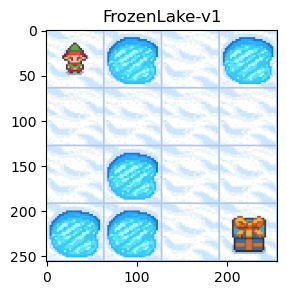

In [2]:
import gym
import time
import numpy as np
from gym.envs.toy_text.frozen_lake import generate_random_map

# 设置随机数种子
np.random.seed(233)

# 创建FrozenLake环境
env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=False, render_mode="rgb_array")

# 重置环境状态
env.reset()

# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env)

简介链接 https://www.gymlibrary.dev/environments/toy_text/frozen_lake/

### 策略迭代

In [3]:
# 策略评估方法，通过迭代计算来估算给定策略条件下的状态值函数
#V当前状态值函数
#policy策略
#gamma折扣因子
#theta阈值
def policy_evaluation(V, policy, gamma, theta):
    while True:
        # 初始化一个delta值，用来衡量在每轮循环后值函数的改变程度
        delta = 0
        # 遍历环境中的每个状态s
        for s in range(env.observation_space.n):
            # 初始化一个变量v，存储计算出的状态值
            v = 0
            # 遍历当前状态下所有可能的动作及其相应的概率
            for a对于每个动作，查看环境所有可能的结果，包括概率、下一个状态、奖励以及是否结束
                for prob, next_state, reward, done in env.P[s][action]:
                    if dction, action_prob in enumerate(policy[s]):
                # one: # 如果这个动作将导致游戏结束，也就没有下一个状态了，则只关心当前的奖励
                        v += action_prob * prob * reward
                    else: # 否则，要考虑当前的奖励和下一个状态的折扣预期值
                        v += (action_prob * prob * (reward + gamma * V[next_state]))
            # 更新delta
            delta = max(delta, np.abs(v - V[s]))
            # 更新状态s的值函数
            V[s] = v
        # 如果所有状态s的值函数变化都小于设定的阈值，则退出循环
        if delta < theta:
            break

In [4]:
len(env.P), env.P[5]

(16,
 {0: [(1.0, 4, 0.0, False)],
  1: [(1.0, 9, 0.0, True)],
  2: [(1.0, 6, 0.0, False)],
  3: [(1.0, 1, 0.0, True)]})

In [5]:
# 策略改进方法，尽可能找到最优策略
def policy_improvent(V, policy, gamma):
    # 初始化标识位，表示是否已找到最优策略
    optimal = True
    # 遍历环境中的每个状态
    for s in range(env.observation_space.n):
        # 保存当前策略以便稍后进行比较
        old_policy = policy[s].copy()
        # 初始化一个数组q_s，用于保存给定状态下所有动作的期望回报
        q_s = np.zeros(env.action_space.n)
        # 对于每个可能的动作，分别计算其期望回报
        for action in range(env.action_space.n):
            # 对于每个动作，查看环境所有可能的结果，包括概率、下一个状态、奖励以及是否结束
            for prob, next_state, reward, done in env.P[s][action]:
                if done: # 如果这个动作将导致游戏结束，也就没有下一个状态了，则只关心当前的奖励
                    q_s[action] += prob * reward
                else: # 否则，还是要考虑当前的奖励和下一个状态的折扣预期值
                    q_s[action] += (prob * (reward + gamma * V[next_state]))
        # 根据每个动作的期望回报选择最佳动作
        best_action = np.argmax(q_s)
        # 更新策略
        policy[s] = np.eye(env.action_space.n)[best_action]
        # 如果新策略与原策略不同，则将标识位设为False
        if np.any(old_policy != policy[s]):
            optimal = False
    # 返回是否找到最优策略
    return optimal

In [6]:
# 策略迭代算法，不断进行策略评估和策略改进
def policy_iteration(gamma = 0.99, max_iteration = 10000, theta = 0.0001):
    # 初始化状态值函数为0，形状为当前环境中状态数量
    V = np.zeros(env.observation_space.n)
    # 初始化策略为随机策略，即每个状态下每个动作的选择概率相等
    policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
    # 循环最大迭代次数
    for i in range(max_iteration):
        # 评估当前策略，更新状态值函数
        policy_evaluation(V, policy, gamma, theta)
        # 对当前策略进行改进，获取是否找到了最优策略
        optimal = policy_improvent(V, policy, gamma)
        # 如果找到了最优策略，则跳出循环
        if optimal:
            break
    # 返回状态值函数和策略
    return V, policy

In [7]:
V, policy = policy_iteration(gamma = 0.99, max_iteration = 10, theta = 0.0001)

In [8]:
V.reshape(4, 4)

array([[0.95099005, 0.        , 0.970299  , 0.        ],
       [0.96059601, 0.970299  , 0.9801    , 0.99      ],
       [0.95099005, 0.        , 0.99      , 1.        ],
       [0.        , 0.        , 1.        , 0.        ]])

In [9]:
policy

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

In [10]:
#每个格子上的最优动作
np.array(["左", "下", "右", "上"])[np.argmax(policy.reshape(4, 4, 4), axis = 2)]

array([['下', '左', '下', '左'],
       ['右', '右', '下', '下'],
       ['上', '左', '下', '下'],
       ['左', '左', '右', '左']], dtype='<U1')

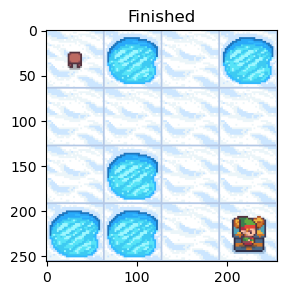

In [12]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env)

# 进行10步的游戏
for i in range(10):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 通过已经求得的最优策略，找到当前状态下的最优动作
    action = np.argmax(policy[observation])
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)
        
    time.sleep(0.5)
    
    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

### 价值迭代

In [12]:
# 价值迭代
def value_iteration(gamma, max_iteration, theta):
    # 初始化状态值函数为0，形状为环境中状态数量
    V = np.zeros(env.observation_space.n)
    # 循环最大迭代次数
    for i in range(max_iteration):
        # 初始化一个delta值，用于保存状态值函数在这次迭代中的最大改变量
        delta = 0
        # 遍历每一个状态
        for s in range(env.observation_space.n):
            # 对每个状态初始化一个动作值函数
            q_s = np.zeros(env.action_space.n)
            # 对每种可能的动作进行循环
            for action in range(env.action_space.n):
                # 获取在给定的状态和动作下，环境的变化情况
                for prob, next_state, reward, done in env.P[s][action]:
                    if done: # 如果这个动作将导致游戏结束，也就没有下一个状态了，则只关心当前的奖励
                        q_s[action] += prob * reward
                    else: # 否则，还是要考虑当前的奖励和下一个状态的折扣预期值
                        q_s[action] += (prob * (reward + gamma * V[next_state]))
            # 计算当前状态的最优动作值函数
            best_value = max(q_s)
            # 更新delta
            delta = max(delta, np.abs(best_value - V[s]))
            # 更新状态值函数
            V[s] = best_value
        # 如果所有状态值函数的改变量都小于阈值theta，则提前终止循环
        if delta < theta:
            break
    # 依据最终的状态值函数获取策略
    policy = get_policy(V, gamma)
    # 返回状态值函数和策略
    return V, policy

# 获取最优策略
def get_policy(V, gamma):
    # 初始化策略，形状为环境中状态数量和动作数量
    policy = np.zeros((env.observation_space.n, env.action_space.n))
    # 遍历每一个状态
    for s in range(env.observation_space.n):
        # 对每个状态初始化一个动作值函数
        q_s = np.zeros(env.action_space.n)
        # 对每种可能的动作进行循环
        for a in range(env.action_space.n):
            # 获取在给定的状态和动作下，环境的变化情况
            for prob, next_state, reward, done in env.P[s][a]:
                if done: # 如果这个动作将导致游戏结束，也就没有下一个状态了，则只关心当前的奖励
                    q_s[a] += prob * reward
                else: # 否则，还是要考虑当前的奖励和下一个状态的折扣预期值
                    q_s[a] += (prob * (reward + gamma * V[next_state]))
        # 选择期望回报最高的动作作为最佳动作
        best_action = np.argmax(q_s)
        # 更新策略，使其在当前状态下选择最佳动作
        policy[s] = np.eye(env.action_space.n)[best_action]
    # 返回策略
    return policy

In [13]:
V, policy = value_iteration(gamma = 0.99, max_iteration = 10, theta = 0.0001)

In [14]:
V.reshape(4, 4)

array([[0.95099005, 0.        , 0.970299  , 0.        ],
       [0.96059601, 0.970299  , 0.9801    , 0.99      ],
       [0.95099005, 0.        , 0.99      , 1.        ],
       [0.        , 0.        , 1.        , 0.        ]])

In [15]:
policy

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

In [16]:
np.array(["左", "下", "右", "上"])[np.argmax(policy.reshape(4, 4, 4), axis = 2)]

array([['下', '左', '下', '左'],
       ['右', '右', '下', '下'],
       ['上', '左', '下', '下'],
       ['左', '左', '右', '左']], dtype='<U1')

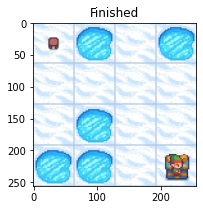

In [17]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env)

# 进行10步的游戏
for i in range(10):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 通过已经求得的最优策略，找到当前状态下的最优动作
    action = np.argmax(policy[observation])
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)
        
    time.sleep(0.5)
    
    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

### 两种方法比较

In [18]:
print(policy_iteration(gamma = 0.99, max_iteration = 10, theta = 0.0001))
print(value_iteration(gamma = 0.99, max_iteration = 10, theta = 0.0001))

(array([0.95099005, 0.        , 0.970299  , 0.        , 0.96059601,
       0.970299  , 0.9801    , 0.99      , 0.95099005, 0.        ,
       0.99      , 1.        , 0.        , 0.        , 1.        ,
       0.        ]), array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]]))
(array([0.95099005, 0.        , 0.970299  , 0.        , 0.96059601,
       0.970299  , 0.9801    , 0.99      , 0.95099005, 0.        ,
       0.99      , 1.        , 0.        , 0.        , 1.        ,
       0.        ]), array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
  